# Data
[Curated Stack Overflow pair of intent and code snippet](https://conala-corpus.github.io/)  

In [73]:
import json
import re
import ast
import sys
import nltk
import traceback
import astor
import token as tk
from tokenize import generate_tokens
from io import StringIO
import itertools 
from gensim.models import FastText
from gensim.models import KeyedVectors
from time import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Variables
train_path="data/conala-corpus/conala-train.json"
test_path="data/conala-corpus/conala-test.json"
train_clean_output_path="data/conala-corpus/.train.seq2seq"
test_clean_output_path="data/conala-corpus/.test.seq2seq"
wordembedding_file_path="data/conala-corpus/embeddings.txt"
docembedding_file_path="data/document_embeddings.csv"

vocab_size=200
window_size=5
min_count=1


In [ ]:
QUOTED_STRING_RE = re.compile(r"(?P<quote>[`'\"])(?P<string>.*?)(?P=quote)")


def canonicalize_intent(intent):
    str_matches = QUOTED_STRING_RE.findall(intent)

    slot_map = dict()

    return intent, slot_map


def replace_strings_in_ast(py_ast, string2slot):
    for node in ast.walk(py_ast):
        for k, v in list(vars(node).items()):
            if k in ('lineno', 'col_offset', 'ctx'):
                continue
            # Python 3
            # if isinstance(v, str) or isinstance(v, unicode):
            if isinstance(v, str):
                if v in string2slot:
                    val = string2slot[v]
                    # Python 3
                    # if isinstance(val, unicode):
                    #     try: val = val.encode('ascii')
                    #     except: pass
                    setattr(node, k, val)
                else:
                    # Python 3
                    # if isinstance(v, str):
                    #     str_key = unicode(v)
                    # else:
                    #     str_key = v.encode('utf-8')
                    str_key = v

                    if str_key in string2slot:
                        val = string2slot[str_key]
                        if isinstance(val, str):
                            try: val = val.encode('ascii')
                            except: pass
                        setattr(node, k, val)


def canonicalize_code(code, slot_map):
    string2slot = {x[1]['value']: x[0] for x in list(slot_map.items())}

    py_ast = ast.parse(code)
    replace_strings_in_ast(py_ast, string2slot)
    canonical_code = astor.to_source(py_ast)

    return canonical_code


def decanonicalize_code(code, slot_map):
    try:
        slot2string = {x[0]: x[1]['value'] for x in list(slot_map.items())}
        py_ast = ast.parse(code)
        replace_strings_in_ast(py_ast, slot2string)
        raw_code = astor.to_source(py_ast)
      # for slot_name, slot_info in slot_map.items():
      #     raw_code = raw_code.replace(slot_name, slot_info['value'])

        return raw_code.strip()
    except:
        return code

def detokenize_code(code_tokens):
    newline_pos = [i for i, x in enumerate(code_tokens) if x == '\n']
    newline_pos.append(len(code_tokens))
    start = 0
    lines = []
    for i in newline_pos:
        line = ' '.join(code_tokens[start: i])
        start = i + 1
        lines.append(line)

    code = '\n'.join(lines).strip()

    return code


def encode_tokenized_code(code_tokens):
    tokens = []
    for token in code_tokens:
        if token == '\t':
            tokens.append('_TAB_')
        elif token == '\n':
            tokens.append('_NEWLINE_')


def get_encoded_code_tokens(code):
    code = code.strip()
    #print(code)
    token_stream = generate_tokens(StringIO(code).readline)
    tokens = []
    indent_level = 0
    new_line = False

    for toknum, tokval, (srow, scol), (erow, ecol), _ in token_stream:
        if toknum == tk.NEWLINE:
            tokens.append('#NEWLINE#')
            new_line = True
        elif toknum == tk.INDENT:
            indent_level += 1
            # new_line = False
            # for i in range(indent_level):
            #     tokens.append('#INDENT#')
        elif toknum == tk.STRING:
            tokens.append(tokval.replace(' ', '#SPACE#').replace('\t', '#TAB#').replace('\r\n', '#NEWLINE#').replace('\n', '#NEWLINE#'))
        elif toknum == tk.DEDENT:
            indent_level -= 1
            # for i in range(indent_level):
            #     tokens.append('#INDENT#')
            # new_line = False
        else:
            tokval = tokval.replace('\n', '#NEWLINE#')
            if new_line:
                for i in range(indent_level):
                    tokens.append('#INDENT#')

            new_line = False
            tokens.append(tokval)

    # remove ending None
    if len(tokens[-1]) == 0:
        tokens = tokens[:-1]

    if '\n' in tokval:
        pass

    return tokens


def tokenize(code):
    token_stream = generate_tokens(StringIO(code).readline)
    tokens = []
    for toknum, tokval, (srow, scol), (erow, ecol), _ in token_stream:
        if toknum == tk.ENDMARKER:
            break

        tokens.append(tokval)

    return tokens


def compare_ast(node1, node2):
    # Python 3
    # if not isinstance(node1, str) and not isinstance(node1, unicode):
    if not isinstance(node1, str):
        if type(node1) is not type(node2):
            return False
    if isinstance(node1, ast.AST):
        for k, v in list(vars(node1).items()):
            if k in ('lineno', 'col_offset', 'ctx'):
                continue
            if not compare_ast(v, getattr(node2, k)):
                return False
        return True
    elif isinstance(node1, list):
        return all(itertools.starmap(compare_ast, zip(node1, node2)))
    else:
        return node1 == node2


def encoded_code_tokens_to_code(encoded_tokens, indent=' '):
    decoded_tokens = []
    for i in range(len(encoded_tokens)):
        token = encoded_tokens[i]
        token = token.replace('#TAB#', '\t').replace('#SPACE#', ' ')

        if token == '#INDENT#': decoded_tokens.append(indent)
        elif token == '#NEWLINE#': decoded_tokens.append('\n')
        else:
            token = token.replace('#NEWLINE#', '\n')
            decoded_tokens.append(token)
            decoded_tokens.append(' ')

    code = ''.join(decoded_tokens).strip()

    return code


def find_sub_sequence(sequence, query_seq):
    for i in range(len(sequence)):
        if sequence[i: len(query_seq) + i] == query_seq:
            return i, len(query_seq) + i

    raise IndexError


def replace_sequence(sequence, old_seq, new_seq):
    matched = False
    for i in range(len(sequence)):
        if sequence[i: i + len(old_seq)] == old_seq:
            matched = True
            sequence[i:i + len(old_seq)] = new_seq
    return matched

In [ ]:
# read and clean data
def read_clean_dataset(dataset_path, output_path):
    train = json.load(open(dataset_path))

    for i, example in enumerate(train):
        # updating `train` in place
        intent = example['intent']

        rewritten_intent = example['rewritten_intent']

        snippet = example['snippet']
        # print(i)
        # code_tokens = get_encoded_code_tokens(snippet)
        # print(' '.join(code_tokens))

        failed = False
        intent_tokens = []
        if rewritten_intent:
            try:
                canonical_intent, slot_map = canonicalize_intent(rewritten_intent)
                #print(canonical_intent, slot_map)

                snippet = snippet
                canonical_snippet = canonicalize_code(snippet, slot_map)
                #print("canonical_snippet:", canonical_snippet, slot_map)

                intent_tokens = nltk.word_tokenize(canonical_intent)

                decanonical_snippet = decanonicalize_code(canonical_snippet, slot_map)
                #print("decanonical_snippet: ",decanonical_snippet)

                snippet_reconstr = astor.to_source(ast.parse(snippet)).strip()
                #print("snippet_reconstr: ",decanonical_snippet)

                decanonical_snippet_reconstr = astor.to_source(ast.parse(decanonical_snippet)).strip()
                #print("decanonical_snippet_reconstr: ",decanonical_snippet_reconstr)
                encoded_reconstr_code = get_encoded_code_tokens(decanonical_snippet_reconstr)
                decoded_reconstr_code = encoded_code_tokens_to_code(encoded_reconstr_code)

                # syntax error in snippet
                if not compare_ast(ast.parse(decoded_reconstr_code), ast.parse(snippet)):
                    print(i)
                    print('Original Snippet: %s' % snippet_reconstr)
                    print('Tokenized Snippet: %s' % ' '.join(encoded_reconstr_code))
                    print('decoded_reconstr_code: %s' % decoded_reconstr_code)

            except:
                print('*' * 20, file=sys.stderr)
                print(i, file=sys.stderr)
                print(intent, file=sys.stderr)
                print(snippet, file=sys.stderr)
                traceback.print_exc()

                failed = True
            finally:
                example['slot_map'] = slot_map

        if rewritten_intent is None:
            encoded_reconstr_code = get_encoded_code_tokens(snippet.strip())
        else:
            encoded_reconstr_code = get_encoded_code_tokens(canonical_snippet.strip())

        if not intent_tokens:
            intent_tokens = nltk.word_tokenize(intent)

        example['intent_tokens'] = intent_tokens
        example['snippet_tokens'] = encoded_reconstr_code

    json.dump(train, open(output_path, 'w'), indent=2)
read_clean_dataset(train_path, train_clean_output_path)
read_clean_dataset(test_path, test_clean_output_path)

# Methods

## 1. Fasttext Word Embedding on both *Intent* and *Snippet*

In [ ]:
train_clean = json.load(open(train_clean_output_path))

In [ ]:
list_keywords=[] # a list of lists of keywords
for i, example in enumerate(train_clean):
    # intent_tokens is from rewritten_intent
    list_keywords.append(set(example["intent_tokens"]+example["snippet_tokens"]))

In [ ]:
st=time()
#[TODO] tuning hyperparameters
model = FastText(size=vocab_size, window=window_size, min_count=min_count)  # instantiate
model.build_vocab(sentences=list_keywords)
model.train(sentences=list_keywords, total_examples=len(list_keywords), epochs=10)  # train
print("Run time: {} s".format(time()-st))

In [ ]:
# save vectors to file if you want to use them later
trained_ft_vectors = model.wv
trained_ft_vectors.save_word2vec_format(wordembedding_file_path, binary=False)

In [ ]:
# load saved wm
st=time()
trained_ft_vectors = KeyedVectors.load_word2vec_format(wordembedding_file_path)
print("Run time: {} s".format(time()-st))

## check cosine similarity between `intent_tokens` and `snippet_tokens` in training set 
should be high

In [ ]:
# build document embedding on `code` only
st=time()
train_size=len(train_clean)
train_ques_list=[] # [{"question_id": int, "intent_tokens": [...]}, ...]
document_embeddings=np.zeros((train_size, vocab_size))
for idx, example in enumerate(train_clean):
    doc_vec_sum=np.zeros(vocab_size)
    train_ques_list.append({"question_id": example["question_id"], "intent_tokens": example["intent_tokens"]})
    for term in example["snippet_tokens"]:
        doc_vec_sum+=trained_ft_vectors[term]
    
    document_embeddings[idx]=doc_vec_sum/len(example["snippet_tokens"])
    
# save the whole document_embeddings
np.savetxt(docembedding_file_path, document_embeddings, delimiter=",")
print("Run time: {} s".format(time()-st))

In [59]:
# normalize a word represenatation vector that its L2 norm is 1.
# we do this so that the cosine similarity reduces to a simple dot product

def normalize(word_representations):
    for word in word_representations:
        total=0
        for key in word_representations[word]:
            total+=word_representations[word][key]*word_representations[word][key]
            
        total=math.sqrt(total)
        for key in word_representations[word]:
            word_representations[word][key]/=total

def dictionary_dot_product(dict1, dict2):
    dot=0
    for key in dict1:
        if key in dict2:
            dot+=dict1[key]*dict2[key]
    return dot

def find_sim(word_representations, query):
    if query not in word_representations:
        print("'%s' is not in vocabulary" % query)
        return None
    
    scores={}
    for word in word_representations:
        cosine=dictionary_dot_product(word_representations[query], word_representations[word])
        scores[word]=cosine
    return scores

# Find the K words with highest cosine similarity to a query in a set of word_representations
def find_nearest_neighbors(word_representations, query, K):
    scores=find_sim(word_representations, query)
    if scores != None:
        sorted_x = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)
        for idx, (k, v) in enumerate(sorted_x[:K]):
            print("%s\t%s\t%.5f" % (idx,k,v))
            
def get_most_relevant_document(tokenized_ques, word_embedding, doc_embedding, num=10):
    """Return the functions that are most relevant to the natual language question.

    Args:
        tokenized_ques: A list. 
        word_embedding: Word embedding generated from codebase.
        doc_embedding: Document embedding generated from codebase
        num: The number of top similar functions to return.

    Returns:
        A list of indices of the top NUM related functions to the QUESTION in the WORD_EMBEDDING.
    
    """
    vec_ques=np.zeros((1,document_embeddings.shape[1])) #vocab_size
    token_count=0
    has_token_in_embedding=False
    for token in tokenized_ques:
        if token in word_embedding:
            has_token_in_embedding=True
            vec_ques+=word_embedding[token]
            token_count+=1
    
    if has_token_in_embedding:
        mean_vec_ques=vec_ques/token_count
    
    
        # compute similarity between this question and each of the source code snippets
        cosine_sim=[]
        for idx, doc in enumerate(document_embeddings):
            #[TODO] fix dimension

            try:
                cosine_sim.append(cosine_similarity(mean_vec_ques, doc.reshape(1, -1))[0][0])
            except ValueError:
                print(question)
                print(vec_ques, token_count)
                print(mean_vec_ques)
                print(doc.reshape(1, -1))
        #print(cosine_sim)
        # get top `num` similar functions
        result=np.array(cosine_sim).argsort()[-num:][::-1]
    else:
        result=np.nan
    return result

In [ ]:
st=time()
list_most_relevant_doc=[] #[{"question_id": int, "similar": [id_in_train_clean]}]
for idx in range(len(train_ques_list)): 
    question_token_list=train_ques_list[idx]["intent_tokens"]
    question_id=train_ques_list[idx]["question_id"]
    
    most_relevant_doc=get_most_relevant_document(question_token_list, trained_ft_vectors, document_embeddings)
    #if question_id in list_most_relevant_doc:
        # this exist
    list_most_relevant_doc.append({"question_id": question_id, "similar": most_relevant_doc})
print("Run time: {} s".format(time()-st)) 

In [ ]:
list_most_relevant_doc

Top 10 cosine similarity are high. <br>
Are the real match in the top 10 code snippet?<br>

# Evaluation
Cosine Similarity between Question Title and Accepted Answer=> should be high

In [ ]:
test_clean = json.load(open(test_clean_output_path))

In [62]:
trained_ft_vectors

In [63]:
def get_doc_embedding(token_list, word_embedding, vocab_size):
    vec_ques=np.zeros((1, vocab_size))
    token_count=0
    has_token_in_embedding=False
    for token in token_list:
        if token in word_embedding:
            has_token_in_embedding=True
            vec_ques+=word_embedding[token]
            token_count+=1
    
    if has_token_in_embedding:
        return vec_ques/token_count
    else:
        return None

In [68]:
st=time()
result=[] #[{"question_id": int, "similar": [id_in_train_clean]}]
for idx in range(len(test_clean)): 
    question_token_list=test_clean[idx]["intent_tokens"]
    question_id=test_clean[idx]["question_id"]
    snippet_token_list=test_clean[idx]["snippet_tokens"]
    
    ques_embed=get_doc_embedding(question_token_list, trained_ft_vectors, vocab_size)
    code_embed=get_doc_embedding(snippet_token_list, trained_ft_vectors, vocab_size)
    
    if ques_embed.all()!=None and code_embed.all()!=None:
        test_clean[idx]["similarity"]=cosine_similarity(ques_embed, code_embed)[0][0]
        
    else:
        print("question_id {} has no token in wm.".format(question_id))

print("Run time: {} s".format(time()-st)) 

Run time: 0.22294878959655762 s


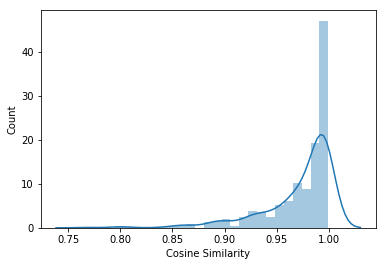

In [79]:
# visualization
vis_data=[]
for i, example in enumerate(test_clean):
    vis_data.append(example["similarity"])
    
sns.distplot(vis_data, axlabel="Cosine Similarity", norm_hist=True)
plt.ylabel("Count");

In [81]:
sum([1 if i>0.95 else 0 for i in vis_data])

406

In [83]:
len(vis_data)

500

In [86]:
len(test_clean)

500

In [85]:
len(train_clean)

2379

In [87]:
500/2379

0.2101723413198823